In [ ]:
# composite task - first single and then sync 
# big arena 8 x 8 - increase all network to 256 neurons
# randomize location of nose poke

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus
import ray
import os
ray.shutdown()
# TODO undo
ray.init(log_to_driver=False, num_gpus = 1)  # Hear the engine humming? ;
import gym
from gym.spaces import Discrete, MultiDiscrete, Box, MultiBinary, Dict
import numpy as np
import random
# from ray.rllib.env.multi_agent_env import MultiAgentEnv

from MultiAgentSync_fullobs_samefield_randnose import MultiAgentSync_fullobs
from MultiAgentSync_fullobs_samefield_randnose import MultiAgentSing_fullobs



[<torch.cuda.device at 0x7f0e5a527940>, <torch.cuda.device at 0x7f0e58388bb0>]

In [5]:
from current_config import current_coop_config, current_sing_config

coop_config, env_config = current_coop_config(limit=5)



agent1 is now mapped to policy1
agent2 is now mapped to policy2


In [6]:

env_config

{'height': 8, 'width': 8, 'sync_limit': 5, 'randomize': True}

In [5]:

env_config = {"height":8,"width":8,"Water1":[7,2],"Water2":[7,6],"Poke1":[0,2],"Poke2":[0,6]}
#env_config = {}


env = MultiAgentSing_fullobs(env_config)
obs = env.reset()

obs, rewards, dones, infos = env.step(action={"agent1":0, "agent2": 3})
obs, rewards, dones, infos = env.step(action={"agent1":0, "agent2": 1})
obs, rewards, dones, infos = env.step(action={"agent1": 0, "agent2": 2})
obs, rewards, dones, infos = env.step(action={"agent1": 0, "agent2": 3})
obs, rewards, dones, infos = env.step(action={"agent1": 0, "agent2": 1})
# obs, rewards, dones, infos = env.step(action={"agent1": 2, "agent2": 2})
# obs, rewards, dones, infos = env.step(action={"agent1": 2, "agent2": 2})
# obs, rewards, dones, infos = env.step(action={"agent1": 2, "agent2": 2})
# # obs, rewards, dones, infos = env.step(action={"agent1": 2, "agent2": 2})
# obs, rewards, dones, infos = env.step(action={"agent1": 2, "agent2": 2})
env.render()

print("Agent1's x/y position={}".format(env.agent1_pos))
print("Agent2's x/y position={}".format(env.agent2_pos))
print(env._get_obs())
#print(env.poke_history1)
#print(env.poke_history2)

__________
|   **   |
|1       |
|        |
|        |
|        |
|     .2 |
|.       |
|        |
‾‾‾‾‾‾‾‾‾‾



R1=-0.5
R2=-0.5

Agent1's x/y position=[1, 0]
Agent2's x/y position=[5, 6]
{'agent1': {'nosepoke': 3, 'water': 24, 'self': 4, 'otheragent': 22, 'otherpoke': 0}, 'agent2': {'nosepoke': 0, 'water': 21, 'self': 22, 'otheragent': 4, 'otherpoke': 3}}


In [6]:
### Provide Config Info: 
## simple_fc_net = FC, simple_rnn_v2: simple rnn 
## simple_rnn_v2_1: EI_relu, simple_rnn_v2_2: EI_abs
## simple_rnn_v2_3: rnn with regularization

from ray.rllib.agents.ppo import PPOTrainer

from simple_rnn_v2_3_2 import AnotherTorchRNNModel
#from simple_rnn_v2_3 import AnotherTorchRNNModel
# from generic_fc_net import FullyConnectedNetwork
from ray.rllib.examples.models.rnn_model import RNNModel, TorchRNNModel
from ray.rllib.utils.test_utils import check_learning_achieved
from ray.rllib.models import ModelCatalog
from ray.rllib.agents.ppo import PPOTorchPolicy
from Customcallback import CustomCallbacks
#ModelCatalog.register_custom_model("simple_fc", CustomFCNet)
ModelCatalog.register_custom_model("rnn2", AnotherTorchRNNModel)
ModelCatalog.register_custom_model("rnnori", AnotherTorchRNNModel)

policies = {
    "policy1": (PPOTorchPolicy, env.observation_space, env.action_space, {}),
    "policy2": (PPOTorchPolicy, env.observation_space, env.action_space, {}),
}

# 2) Defines an agent->policy mapping function.
def policy_mapping_fn(agent_id: str) -> str:
    # Make sure agent ID is valid.
    assert agent_id in ["agent1", "agent2"], f"ERROR: invalid agent ID {agent_id}!"
    ### Modify Code here ####
    id = agent_id[-1]
    return f'policy{id}'

config3 = {
    "env": MultiAgentSing_fullobs,  # "my_env" <- if we previously have registered the env with `tune.register_env("[name]", lambda config: [returns env object])`.
    "env_config": env_config,
    "num_workers": 0,
    "exploration_config": {
    "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    #"type": ParameterNoiseCuriosity,
    #"noise_stddev": 0.0005,
    "eta": 1.5,  # Weight for intrinsic rewards before being added to extrinsic ones.
    "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    "feature_dim": 64,  # Dimensionality of the generated feature vectors.
    # Setup of the feature net (used to encode observations into feature (latent) vectors).
        # FIXME
    "feature_net_config": {"use_lstm": False,},
    #"inverse_net_hiddens": [256,256],  # Hidden layers of the "inverse" model.
    "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    "inverse_net_activation": "relu",  # Activation of the "inverse" model.
        # FIXME
    "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    #"forward_net_hiddens": [256,256],  # Hidden layers of the "forward" model.
    "forward_net_activation": "relu",  # Activation of the "forward" model.
    "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    # Specify, which exploration sub-type to use (usually, the algo's "default"
    # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).

    "sub_exploration": {
        "type": "StochasticSampling",
      }
    },
    # !PyTorch users!
    "framework": "torch",  # If users have chosen to install torch instead of tf.
    "create_env_on_driver": True,
}

max_seq_len = 10;

#3) RNN config.
config3.update({
    "multiagent": {
        "policies": policies,
        "policy_mapping_fn": policy_mapping_fn,
    },
     "model": {
            "custom_model": "rnn2",
            "max_seq_len": max_seq_len,
            "custom_model_config": {
                #"fc_size": 128,
                "rnn_hidden_size": 256,
                "l2_lambda":0.1,
                "l2_lambda_inp":0,
                "noise_std": 1,
                "device": torch.device("cuda:0")
            },
        },
    "num_workers": 0,
    "num_gpus": 0.3,
   "callbacks": CustomCallbacks,
})

# config.update({"kl_coeff": 0.0,
#               "kl_target":0.0}) # remove kl

print()
print(f"agent1 is now mapped to {policy_mapping_fn('agent1')}")
print(f"agent2 is now mapped to {policy_mapping_fn('agent2')}")
# 


agent1 is now mapped to policy1
agent2 is now mapped to policy2


In [9]:
# agent = PPOTrainer(config = config3)
# results = agent.train()
name = "bigarena_single_randnose_rnn_n1_8"
checkpoint_dir = f"/home/kumquat/Documents/Linfan/MARL/trainings/{name}"

In [10]:
# # train with ray tune
from ray import tune
n_it = 6000

analysis = tune.run("PPO", 
    config=config3, 
    checkpoint_freq=10,
    checkpoint_at_end=True,
    stop = { #"timesteps_total": NUMBER_OF_TIMESTEPS_TO_SAMPLE,
             "training_iteration": n_it,
            #"episode_reward_mean": 60,
           },
    local_dir=checkpoint_dir,
    verbose = 1,
#resume = True,
);

2023-10-21 18:00:19,845	INFO tune.py:762 -- Total run time: 188869.12 seconds (188868.35 seconds for the tuning loop).


In [11]:
#rom ray import tune
#checkpoint_dir = r"D:\Linfan\RL-cooperation\checkpoints_composite_task\bigarena_single_randnose_rnn_n1_rr_e-3"
analysis = tune.ExperimentAnalysis(checkpoint_dir)
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"), 
    metric="episode_reward_mean")

rewards_learn = list();
for i in range(len(checkpoints)):

    rewards_learn.append(checkpoints[i][1])


2023-10-23 13:01:30,096	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


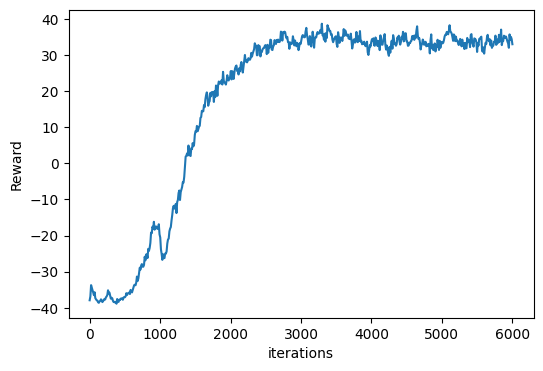

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6,4))
x = np.linspace(0,10*len(checkpoints),len(checkpoints))
plt.plot(x,rewards_learn)
plt.xlabel('iterations')
plt.ylabel('Reward');

In [13]:
max_number = np.max(rewards_learn)
max_iteration = np.where(rewards_learn == max_number)[0][0]
print(checkpoints[max_iteration])

('/home/kumquat/Documents/Linfan/MARL/trainings/bigarena_single_randnose_rnn_n1_8/PPO/PPO_MultiAgentSing_fullobs_a0533_00000_0_2023-10-19_13-32-30/checkpoint_003300', 38.63999999999977)


In [14]:
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"), 
    metric="episode_reward_mean")

# list of lists: one list per checkpoint; each checkpoint list contains
# 1st the path, 2nd the metric value 

agent = PPOTrainer(config=config3)
agent.restore(checkpoints[max_iteration][0])


2023-07-24 18:33:40,516	INFO algorithm.py:457 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-07-24 18:33:40,519	WARNING env.py:247 -- Your MultiAgentEnv <MultiAgentSing_fullobs instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
2023-07-24 18:33:40,525	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-24 18:33:42,295	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-24 18:33:42,347	INFO trainable.py:766 -- Restored on 127.0.0.1 from checkpoint: D:\Linfan\RL-cooperation\checkpoints_composite_task\bigarena_single_randnose_rnn_n1_rr_e-3\PPO\PPO_MultiAgentSing_fullobs_64

In [15]:
#agent = agents_update

import time
from ipywidgets import Output
from IPython import display
out = Output()
display.display(out)
 
with out:
    env = MultiAgentSing_fullobs(env_config)
    obs = env.reset()
    state1 = [np.zeros(256, np.float32) for _ in range(1)]
    state2 = [np.zeros(256, np.float32) for _ in range(1)]
    a1 = 0; a2 = 0;
    rewards = {"agent1": 0, "agent2": 0}
    while True:
        a1,state1,_ = agent.compute_single_action(observation=obs["agent1"], state=state1,policy_id="policy1")
        #print(a1)
        a2,state2,_ = agent.compute_single_action(observation=obs["agent2"], state=state2,policy_id="policy2")
        obs, rewards, dones, _ = env.step({"agent1": a1, "agent2": a2})
        #print(env.agent1_pos)
        out.clear_output(wait=True)
        time.sleep(0.2)
        env.render()  
        if dones["agent1"]:
            break

Output()

In [14]:
# get pre-trained weights 
#from ray import tune
#checkpoint_dir = r"D:\Linfan\RL-cooperation\checkpoints_composite_task\bigarena_single_randnose_rnn_n1_2"
analysis = tune.ExperimentAnalysis(checkpoint_dir)
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean")
agent = PPOTrainer(config=config3)
agent.restore(checkpoints[max_iteration][0]) # 1000 iterations
print(checkpoints[max_iteration][1])
weights = agent.get_weights()

2023-10-23 13:02:17,589	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2023-10-23 13:02:18,077	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-10-23 13:02:18,080	WARNING env.py:247 -- Your MultiAgentEnv <MultiAgentSing_fullobs instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
2023-10-23 13:02:18,083	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-10-23 13:02:18,963	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-10-23

38.63999999999977


In [15]:
configsync = config3.copy()
env_config_s1 = {"height":8,"width":8,"Water1":[7,2],"Water2":[7,6],"Poke1":[0,2],"Poke2":[0,6],"sync_limit":5}
configsync.update({"env":MultiAgentSync_fullobs,
                  "env_config":env_config_s1})

In [16]:
agents_update = PPOTrainer(config=configsync)
agents_update.set_weights(weights)

2023-10-23 13:02:21,966	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-10-23 13:02:21,982	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-10-23 13:02:21,995	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [17]:

folder_name = os.path.basename(os.path.normpath(checkpoint_dir))
folder_name = 'bigarena_sync_s1_'+folder_name[16:]
bigfolder = "/home/kumquat/Documents/Linfan/MARL/trainings/"
path = os.path.join(bigfolder, folder_name)
path

'/home/kumquat/Documents/Linfan/MARL/trainings/bigarena_sync_s1_randnose_rnn_n1_8'

In [18]:
rewards_learn = list()
rewards1 = list()
rewards2 = list()
nmiss1 = list()
nmiss2 = list()
ncorrect = list()
for i in range(2000):
    result = agents_update.train()

    # Add any necessary logging or monitoring code here
    rewards_learn.append(result['episode_reward_mean'])
    nmiss1.append(result['custom_metrics']['nmiss1_mean'])
    nmiss2.append(result['custom_metrics']['nmiss2_mean']) 
    ncorrect.append(result['custom_metrics']['ncorrect_mean'])
    rewards1.append(result['policy_reward_mean']['policy1'])
    rewards2.append(result['policy_reward_mean']['policy2'])
    
    if (i+1)%10 == 0:
        print('iteration' + str(i+1) + ' reward = ' + str(result['episode_reward_mean']) + 'nMiss = ' + str(result['custom_metrics']['nmiss1_mean']) + '+' + str(result['custom_metrics']['nmiss2_mean']) + 'Correct = ' + str(result['custom_metrics']['ncorrect_mean']))
    # Check stopping criteria if needed
        checkpoint_path = path#os.path.join(path, f"checkpoint_iteration_{i}.pth")
        agents_update.save(checkpoint_path)


2023-10-23 13:02:28,135	WARNING deprecation.py:47 -- DeprecationWarning: `policy_mapping_fn(agent_id)` has been deprecated. Use `policy_mapping_fn(agent_id, episode, worker, **kwargs)` instead. This will raise an error in the future!
2023-10-23 13:02:40,510	WARNING deprecation.py:47 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!


iteration10 reward = -5.331000000000012nMiss = 4.45+4.64Correct = 5.28
iteration20 reward = -4.5720000000000205nMiss = 4.1+4.68Correct = 5.51
iteration30 reward = -6.314000000000008nMiss = 3.74+4.29Correct = 5.03
iteration40 reward = -0.6190000000000153nMiss = 4.07+3.95Correct = 5.79
iteration50 reward = -2.602000000000012nMiss = 4.14+3.59Correct = 5.47
iteration60 reward = 0.059999999999981526nMiss = 3.74+3.19Correct = 5.72
iteration70 reward = 3.946999999999992nMiss = 3.45+2.58Correct = 6.03
iteration80 reward = 5.701999999999993nMiss = 3.1+2.5Correct = 6.29
iteration90 reward = 7.884999999999984nMiss = 2.81+2.56Correct = 6.54
iteration100 reward = 6.546999999999997nMiss = 3.19+2.96Correct = 6.35
iteration110 reward = 6.024999999999994nMiss = 3.29+3.04Correct = 6.52
iteration120 reward = 7.95299999999997nMiss = 2.87+2.68Correct = 6.74
iteration130 reward = 7.747999999999951nMiss = 2.84+2.39Correct = 6.44
iteration140 reward = 12.316999999999966nMiss = 2.64+1.92Correct = 6.9
iteration

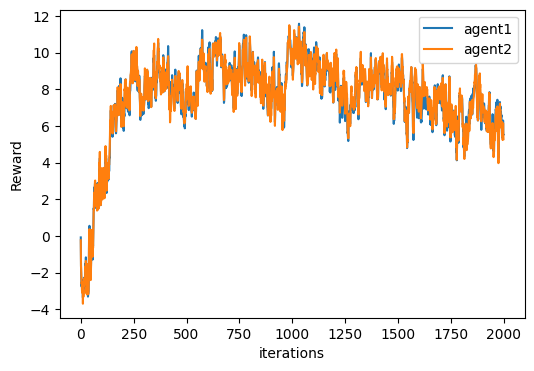

In [19]:
from scipy.io import savemat
savemat(os.path.join(bigfolder, folder_name + '.rewards_learn.mat'), {'rewards_learn': rewards_learn,"rewards1":rewards1,"rewards2":rewards2,"nmiss1":nmiss1,"nmiss2":nmiss2,'ncorrect':ncorrect})
import matplotlib.pyplot as plt
plt.figure(figsize = (6,4))
x = range(len(rewards_learn))
plt.plot(x,rewards1,label='agent1')
plt.plot(x,rewards2,label='agent2')
plt.xlabel('iterations')
plt.ylabel('Reward')
plt.legend();
plt.figure(figsize = (6,4))
x = range(len(rewards_learn))
plt.plot(x,nmiss1,label='miss1')
plt.plot(x,nmiss2,label='miss2')
plt.plot(x,ncorrect,label='correct')
plt.xlabel('iterations')
plt.ylabel('number/episode')
plt.legend();

In [20]:
# find which iteration has the highest reward
#rewards_learn = lmat['rewards_learn'][0]
reward_array = np.array(rewards_learn)
indices = np.arange(9, len(reward_array), 10)
selected_numbers = reward_array[indices]
max_number = np.max(selected_numbers)
max_iteration = np.where(reward_array == max_number)[0][0]
formatted_index = str(max_iteration+1).zfill(6)
path_res = os.path.join(path,"checkpoint_"+formatted_index)
print(f"best iteration {max_iteration+1} rewards {rewards_learn[max_iteration]}")

best iteration 1010 rewards 22.277999999999903


In [21]:
agents_update = PPOTrainer(config=configsync)
agents_update.restore(path_res)
weights = agents_update.get_weights()
configsync2 = config3.copy()
env_config_s2 = {"height":8,"width":8,"Water1":[7,2],"Water2":[7,6],"Poke1":[0,2],"Poke2":[0,6],"sync_limit":2}
configsync2.update({"env":MultiAgentSync_fullobs,
                  "env_config":env_config_s2})
agents_update2 = PPOTrainer(config=configsync2)
agents_update2.set_weights(weights)


2023-10-24 02:31:17,778	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-10-24 02:31:17,796	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-10-24 02:31:17,813	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-10-24 02:31:17,830	INFO trainable.py:790 -- Restored on 10.47.57.245 from checkpoint: /home/kumquat/Documents/Linfan/MARL/trainings/bigarena_sync_s1_randnose_rnn_n1_8/checkpoint_001010
2023-10-24 02:31:17,830	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 1010, '_timesteps_total': None, '_time_total': 22993.450441360474, '_episodes_total': 20200}
2023-10-24 02:31:17,838	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-10-24 02:31:17,8

In [22]:

folder_name = os.path.basename(os.path.normpath(checkpoint_dir))
folder_name = 'bigarena_sync_s2_'+folder_name[16:]
path = os.path.join(bigfolder, folder_name)
path

'/home/kumquat/Documents/Linfan/MARL/trainings/bigarena_sync_s2_randnose_rnn_n1_8'

In [23]:
rewards_learn = list()
rewards1 = list()
rewards2 = list()
nmiss1 = list()
nmiss2 = list()
ncorrect = list()
for i in range(10000):
    result = agents_update2.train()

    # Add any necessary logging or monitoring code here
    rewards_learn.append(result['episode_reward_mean'])
    nmiss1.append(result['custom_metrics']['nmiss1_mean'])
    nmiss2.append(result['custom_metrics']['nmiss2_mean']) 
    ncorrect.append(result['custom_metrics']['ncorrect_mean'])
    rewards1.append(result['policy_reward_mean']['policy1'])
    rewards2.append(result['policy_reward_mean']['policy2'])
    
    if (i+1)%10 == 0:
        print('iteration' + str(i+1) + ' reward = ' + str(result['episode_reward_mean']) + 'nMiss = ' + str(result['custom_metrics']['nmiss1_mean']) + '+' + str(result['custom_metrics']['nmiss2_mean']) + 'Correct = ' + str(result['custom_metrics']['ncorrect_mean']))
    # Check stopping criteria if needed
        checkpoint_path = path#os.path.join(path, f"checkpoint_iteration_{i}.pth")
        agents_update2.save(checkpoint_path)


iteration10 reward = -11.697000000000052nMiss = 4.24+4.12Correct = 4.34
iteration20 reward = -3.985000000000009nMiss = 3.42+3.65Correct = 5.11
iteration30 reward = -2.9340000000000295nMiss = 3.32+3.31Correct = 5.13
iteration40 reward = -10.21200000000004nMiss = 4.0+3.16Correct = 4.35
iteration50 reward = -8.411000000000024nMiss = 3.82+3.33Correct = 4.55
iteration60 reward = -4.484000000000022nMiss = 3.29+3.24Correct = 5.1
iteration70 reward = 0.3430000000000031nMiss = 3.36+2.83Correct = 5.47
iteration80 reward = -2.25700000000003nMiss = 3.72+3.0Correct = 5.33
iteration90 reward = -4.33600000000001nMiss = 3.33+3.32Correct = 5.07
iteration100 reward = 0.18899999999997555nMiss = 3.14+2.96Correct = 5.59
iteration110 reward = 3.822999999999973nMiss = 3.35+2.98Correct = 6.21
iteration120 reward = 1.9949999999999788nMiss = 3.08+3.09Correct = 5.85
iteration130 reward = 2.7229999999999728nMiss = 3.12+2.93Correct = 5.96
iteration140 reward = 0.9149999999999865nMiss = 2.95+3.21Correct = 5.68
iter

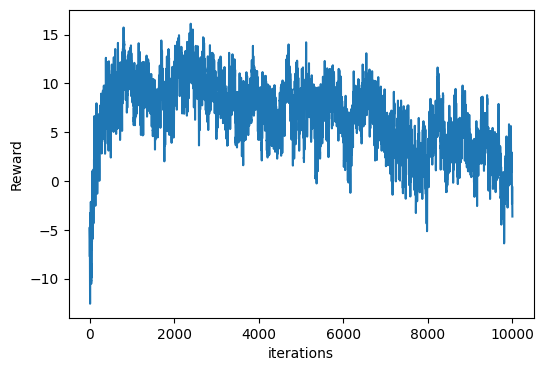

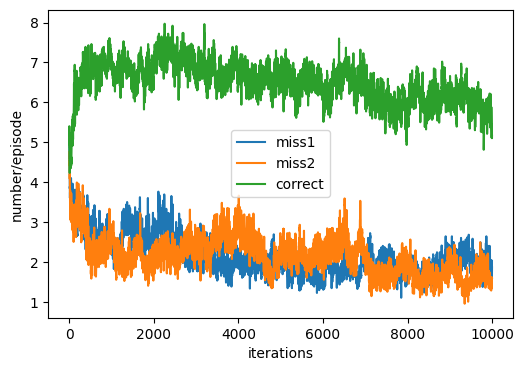

In [24]:
from scipy.io import savemat
savemat(os.path.join(bigfolder, folder_name + '.rewards_learn.mat'), {'rewards_learn': rewards_learn,"rewards1":rewards1,"rewards2":rewards2,"nmiss1":nmiss1,"nmiss2":nmiss2,'ncorrect':ncorrect})
import matplotlib.pyplot as plt
plt.figure(figsize = (6,4))
x = range(len(rewards_learn)) 
plt.plot(x,rewards_learn)
plt.xlabel('iterations')
plt.ylabel('Reward');
plt.figure(figsize = (6,4))
x = range(len(rewards_learn))
plt.plot(x,nmiss1,label='miss1')
plt.plot(x,nmiss2,label='miss2')
plt.plot(x,ncorrect,label='correct')
plt.xlabel('iterations')
plt.ylabel('number/episode')
plt.legend();

In [25]:
# find the best iteration 
reward_array = np.array(rewards_learn)
indices = np.arange(9, len(reward_array), 10)
selected_numbers = reward_array[indices]
max_number = np.max(selected_numbers)
max_iteration = np.where(reward_array == max_number)[0][0]
formatted_index = str(max_iteration+1).zfill(6)
path_res = os.path.join(path,"checkpoint_"+formatted_index)
print(f"best iteration {max_iteration+1} rewards {rewards_learn[max_iteration]}")

best iteration 2390 rewards 15.70299999999995


In [45]:
checkpoint = '/home/kumquat/Documents/Linfan/MARL/trainings/bigarena_sync_s2_randnose_rnn_n1_1/checkpoint_001690'
agent = PPOTrainer(config=configsync2)
agent.restore(checkpoint)

import time
from ipywidgets import Output
from IPython import display
out = Output()
display.display(out)
 
with out:
    env = MultiAgentSync_fullobs(env_config_s2)
    env.timestep_limit = 500
    obs = env.reset()
    state1 = [np.zeros(256, np.float32) for _ in range(2)]
    state2 = [np.zeros(256, np.float32) for _ in range(2)]
    a1 = 0; a2 = 0;
    rewards = {"agent1": 0, "agent2": 0}
    while True:
        a1,state1,_ = agent.compute_single_action(observation=obs["agent1"], state=state1,policy_id="policy1")
        #print(a1)
        a2,state2,_ = agent.compute_single_action(observation=obs["agent2"], state=state2,policy_id="policy2")
        obs, rewards, dones, _ = env.step({"agent1": a1, "agent2": a2})
        #print(env.agent1_pos)
        out.clear_output(wait=True)
        time.sleep(0.2)
        env.render() 
        if dones["agent1"]:
            break

2023-10-13 18:45:59,778	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-10-13 18:45:59,799	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-10-13 18:45:59,818	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-10-13 18:45:59,847	INFO trainable.py:790 -- Restored on 10.47.57.245 from checkpoint: /home/kumquat/Documents/Linfan/MARL/trainings/bigarena_sync_s2_randnose_rnn_n1_1/checkpoint_001690
2023-10-13 18:45:59,847	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 1690, '_timesteps_total': None, '_time_total': 39081.445711135864, '_episodes_total': 33800}


Output()

In [31]:
# export activation of the rnn layer and input at native and well-trained stage - one iteration
# 10 roll outs of 500 steps



checkpoint =  r"D:\\Linfan\\RL-cooperation\\checkpoints_composite_task\\bigarena_sync_s2_randnose_rnn_n1_1\checkpoint_003390"
agent = PPOTrainer(config=configsync2)
agent.restore(checkpoint)

model_1 = agent.get_policy('policy1').model
model_2 = agent.get_policy('policy2').model

ts = 500
activation1 = list()
activation2 = list()
loc1 = list()
loc2 = list()
waterloc1 = list()
waterloc2 = list()
nploc1 = list()
nploc2 = list()
miss = list()
correct = list()
for _ in range(10): # 10 roll outs
# # # Clear activations
    model_1.activations = {}
    model_2.activations = {}
    # # enable activation saving.
    model_1.register_activation_hooks()
    model_2.register_activation_hooks()

    # the location of each agent
    env = MultiAgentSync_fullobs(config = env_config_s2)
    env.timestep_limit = ts
    obs = env.reset()
    state1 = [np.zeros(256, np.float32) for _ in range(1)]
    state2 = [np.zeros(256, np.float32) for _ in range(1)]

    while True:
        loc1.append(obs['agent1']['self'])
        loc2.append(obs['agent2']['self'])
        waterloc1.append(obs['agent1']['water'])
        waterloc2.append(obs['agent2']['water'])
        nploc1.append(obs['agent1']['nosepoke'])
        nploc2.append(obs['agent2']['nosepoke'])
        a1,state_out1,obsfl_1 = agent.compute_single_action(obs['agent1'], state1, policy_id='policy1')
        a2,state_out2,obsfl_2 = agent.compute_single_action(obs['agent2'], state2, policy_id='policy2')
        obs, rewards, dones, events = env.step({'agent1': a1, 'agent2': a2})
        correct.append(env.sync_poke)
        miss.append(env.miss)
        if dones['agent1']==True:
            break
        else:
            state1 = state_out1[:]
            state2 = state_out2[:] 

    for t in range(ts):
        activation1.append(model_1.activations['rnn'][t][0][0].tolist())
        activation2.append(model_2.activations['rnn'][t][0][0].tolist())
        
    model_1.deregister_activation_hooks()
    model_2.deregister_activation_hooks()

2023-07-12 22:09:46,078	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-12 22:09:46,105	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-12 22:09:46,159	INFO trainable.py:766 -- Restored on 127.0.0.1 from checkpoint: D:\Linfan\RL-cooperation\checkpoints_composite_task\bigarena_sync_s2_randnose_rnn_n1_1\checkpoint_003390
2023-07-12 22:09:46,159	INFO trainable.py:775 -- Current state after restoring: {'_iteration': 3390, '_timesteps_total': None, '_time_total': 159569.1961760521, '_episodes_total': 67800}


In [32]:
from scipy.io import savemat
savemat("activations_composite_coop_rand_np_10x500.mat", {'activations1': activation1,'activations2': activation2,'agent1loc':loc1,'agent2loc':loc2,'water1loc':waterloc1,'water2loc':waterloc2,'nploc1':nploc1,'nploc2':nploc2,'miss':miss,'correct':correct})

In [27]:
# export activation of the rnn layer and input at native and well-trained stage - one iteration
# 10 roll outs of 500 steps



checkpoint = r"D:\Linfan\RL-cooperation\checkpoints_composite_task\bigarena_single_randnose_rnn_n1_1"
analysis = tune.ExperimentAnalysis(checkpoint)
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean")
agent = PPOTrainer(config=config3)
agent.restore(checkpoints[-1][0]) # 1000 iterations


model_1 = agent.get_policy('policy1').model
model_2 = agent.get_policy('policy2').model

ts = 500
activation1 = list()
activation2 = list()
loc1 = list()
loc2 = list()
waterloc1 = list()
waterloc2 = list()
nploc1 = list()
nploc2 = list()
miss = list()
correct = list()
for _ in range(10): # 10 roll outs
# # # Clear activations
    model_1.activations = {}
    model_2.activations = {}
    # # enable activation saving.
    model_1.register_activation_hooks()
    model_2.register_activation_hooks()

    # the location of each agent
    env = MultiAgentSing_fullobs(config = env_config)
    env.timestep_limit = ts
    obs = env.reset()
    state1 = [np.zeros(256, np.float32) for _ in range(1)]
    state2 = [np.zeros(256, np.float32) for _ in range(1)]

    while True:
        loc1.append(obs['agent1']['self'])
        loc2.append(obs['agent2']['self'])
        waterloc1.append(obs['agent1']['water'])
        waterloc2.append(obs['agent2']['water'])
        nploc1.append(obs['agent1']['nosepoke'])
        nploc2.append(obs['agent2']['nosepoke'])
        a1,state_out1,obsfl_1 = agent.compute_single_action(obs['agent1'], state1, policy_id='policy1')
        a2,state_out2,obsfl_2 = agent.compute_single_action(obs['agent2'], state2, policy_id='policy2')
        obs, rewards, dones, events = env.step({'agent1': a1, 'agent2': a2})
        correct.append(env.sync_poke)
        miss.append(env.miss)
        if dones['agent1']==True:
            break
        else:
            state1 = state_out1[:]
            state2 = state_out2[:] 

    for t in range(ts):
        activation1.append(model_1.activations['rnn'][t][0][0].tolist())
        activation2.append(model_2.activations['rnn'][t][0][0].tolist())
        
    model_1.deregister_activation_hooks()
    model_2.deregister_activation_hooks()

2023-07-12 21:51:32,434	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2023-07-12 21:51:32,715	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-12 21:51:32,735	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-12 21:51:32,779	INFO trainable.py:766 -- Restored on 127.0.0.1 from checkpoint: D:\Linfan\RL-cooperation\checkpoints_composite_task\bigarena_single_randnose_rnn_n1_1\PPO\PPO_MultiAgentSing_fullobs_a50aa_00000_0_2023-06-22_17-12-31\checkpoint_003000
2023-07-12 21:51:32,780	INFO trainable.py:775 -- Current state after restoring: {'_iteration': 3000, '_timesteps_total': None, '_time_total': 106067.33444809914, '_episodes_total': 60000}


In [28]:
from scipy.io import savemat
savemat("activations_composite_sing_rand_np_10x500.mat", {'activations1': activation1,'activations2': activation2,'agent1loc':loc1,'agent2loc':loc2,'water1loc':waterloc1,'water2loc':waterloc2,'nploc1':nploc1,'nploc2':nploc2,'miss':miss,'correct':correct})

In [17]:
from scipy.io import savemat
checkpoint = r"D:\\Linfan\\RL-cooperation\\checkpoints_composite_task\\bigarena_sync_s2_randnose_rnn_n1_1\checkpoint_003390"
agent = PPOTrainer(config=configsync2)
agent.restore(checkpoint)
weights = agent.get_weights()
input_weight = list()
input_weight.append(weights['policy1']['rnn.weight_ih_l0'])
input_weight.append(weights['policy2']['rnn.weight_ih_l0'])
output_weight = list()
output_weight.append(weights['policy1']['action_branch.weight'])
output_weight.append(weights['policy2']['action_branch.weight'])
savemat("inputweight_randnp_coop.mat", {'iw': input_weight,"ow":output_weight})

2023-07-12 17:09:04,734	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-12 17:09:04,776	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-12 17:09:04,840	INFO trainable.py:766 -- Restored on 127.0.0.1 from checkpoint: D:\Linfan\RL-cooperation\checkpoints_composite_task\bigarena_sync_s2_randnose_rnn_n1_1\checkpoint_003390
2023-07-12 17:09:04,841	INFO trainable.py:775 -- Current state after restoring: {'_iteration': 3390, '_timesteps_total': None, '_time_total': 159569.1961760521, '_episodes_total': 67800}


In [18]:

checkpoint_dir = r"D:\Linfan\RL-cooperation\checkpoints_composite_task\bigarena_single_randnose_rnn_n1_1"
analysis = tune.ExperimentAnalysis(checkpoint_dir)
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean")
agent = PPOTrainer(config=config3)
agent.restore(checkpoints[-1][0]) # 1000 iterations
weights = agent.get_weights()
input_weight = list()
input_weight.append(weights['policy1']['rnn.weight_ih_l0'])
input_weight.append(weights['policy2']['rnn.weight_ih_l0'])
output_weight = list()
output_weight.append(weights['policy1']['action_branch.weight'])
output_weight.append(weights['policy2']['action_branch.weight'])
savemat("inputweight_randnp_sing.mat", {'iw': input_weight,"ow":output_weight})

2023-07-12 17:09:08,108	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
2023-07-12 17:09:08,440	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-12 17:09:08,473	WARNING catalog.py:641 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-07-12 17:09:08,550	INFO trainable.py:766 -- Restored on 127.0.0.1 from checkpoint: D:\Linfan\RL-cooperation\checkpoints_composite_task\bigarena_single_randnose_rnn_n1_1\PPO\PPO_MultiAgentSing_fullobs_a50aa_00000_0_2023-06-22_17-12-31\checkpoint_003000
2023-07-12 17:09:08,551	INFO trainable.py:775 -- Current state after restoring: {'_iteration': 3000, '_timesteps_total': None, '_time_total': 106067.33444809914, '_episodes_total': 60000}
